In [1]:
import torch 
import numpy as np 
from deep_ensemble import deep_ensemble_FP as deep_ensemble_MLP
from deep_ensemble import deep_ensemble_Graph as deep_ensemble_Graph
import math 
import argparse
import sys
from tqdm import tqdm 
from collections import OrderedDict
import matplotlib.pyplot as plt
# import get_fsmol_dataloader as fsmol
import seaborn as sns
from EDKT_data.Data_FP_fsmol import deep_gp_data as deep_gp_data_fp
from EDKT_data.Data_Graph_fsmol import deep_gp_data as deep_gp_data_graph
import pickle 
import os

## Load Data

In [2]:
assay_id_train_test_split = np.load('../Data_for_publication/fsmol/split_dic.pkl', allow_pickle=True)
test_assay_ls = assay_id_train_test_split['test_assays']
eval_assay_ls = assay_id_train_test_split['valid_assays']

few_shot_number = 32

# load fp data
data_path = '../Data_for_publication/fsmol/all_data_fp.pkl'
data_path_test = f'../Data_for_publication/fsmol/all_data_fp_test_10fold_{few_shot_number}.pkl'
data_path_valid = f'../Data_for_publication/fsmol/all_data_fp_valid_10fold_{few_shot_number}.pkl'
data_test_fp = deep_gp_data_fp(data_path, data_path_test)
data_valid_fp = deep_gp_data_fp(data_path, data_path_valid)
# load graph data
data_path = '../Data_for_publication/fsmol/all_data_graph.pkl'
data_path_test = f'../Data_for_publication/fsmol/all_data_graph_test_10fold_{few_shot_number}.pkl'
data_path_valid = f'../Data_for_publication/fsmol/all_data_graph_valid_10fold_{few_shot_number}.pkl'
data_test_graph = deep_gp_data_graph(data_path, data_path_test)
data_valid_graph = deep_gp_data_graph(data_path, data_path_valid)

## Load Model 

In [3]:
def parse_args(args_list=None):
    parser = argparse.ArgumentParser(description="DeepGP Training Script")
    parser.add_argument("--random_seed", type=int, default=42, help="random_seed")
    parser.add_argument("--dataset", type=str, help="what dataset to use", default='fsmol')
    parser.add_argument("--encode_method", type=str, help="what encoder to use", default='FP')
    parser.add_argument("--num_encoder", type=int, default=2, help="num_encoder")
    parser.add_argument("--allow_NCL", action="store_true", help="whether use NCL")
    
    # First parse to get dataset and encode_method
    temp_args, _ = parser.parse_known_args(args_list)
    
    if temp_args.dataset == 'fsmol':
        parser.add_argument("--FP_input_dim", type=int, default=2024, help="FP input dimension")
        parser.add_argument("--Graph_input_dim", type=int, default=32, help="Graph input dimension")
    elif temp_args.dataset == 'pQSAR':
        parser.add_argument("--FP_input_dim", type=int, default=1024, help="FP input dimension")
        parser.add_argument("--Graph_input_dim", type=int, default=30, help="Graph input dimension")
        parser.add_argument("--group_id", type=int, default=0, help="group_id")
    
    parser.add_argument("--world_size", type=int, default=6, help="number of GPUs to use")
    parser.add_argument("--batch_size", type=int, default=10, help="batch size")
    if 'FP' in temp_args.encode_method:
        parser.add_argument("--lr", type=float, help="learning rate", default=0.001)
    elif 'Graph' in temp_args.encode_method:
        parser.add_argument("--lr", type=float, help="learning rate", default=0.0005)
    
    args = parser.parse_args(args_list)
    
    # Import required modules based on arguments
    if 'FP' in args.encode_method:
        from deep_ensemble import deep_ensemble_FP as deep_ensemble
        if args.dataset == 'fsmol':
            from EDKT_data.Data_FP_fsmol import deep_gp_data
            from DKT_dataset import MLP_train_dataset_fsmol as train_dataset 
            from DKT_dataset import MLP_eval_dataset_fsmol as eval_dataset
        elif args.dataset == 'pQSAR':
            from EDKT_data.Data_FP_pQSAR import deep_gp_data
            from DKT_dataset import MLP_train_dataset_pQSAR as train_dataset
            from DKT_dataset import MLP_eval_dataset_pQSAR as eval_dataset
    elif 'Graph' in args.encode_method:
        from deep_ensemble import deep_ensemble_Graph as deep_ensemble
        if args.dataset == 'fsmol':
            from EDKT_data.Data_Graph_fsmol import deep_gp_data
            from DKT_dataset import Graph_train_dataset_fsmol as train_dataset
            from DKT_dataset import Graph_eval_dataset_fsmol as eval_dataset
        elif args.dataset == 'pQSAR':
            from EDKT_data.Data_Graph_pQSAR import deep_gp_data
            from DKT_dataset import Graph_train_dataset_pQSAR as train_dataset
            from DKT_dataset import Graph_eval_dataset_pQSAR as eval_dataset
    
    # Add imported modules to args
    args.deep_ensemble = deep_ensemble
    args.deep_gp_data = deep_gp_data
    args.train_dataset = train_dataset
    args.eval_dataset = eval_dataset
    
    return args

#### Load FP model 

In [4]:
import importlib
importlib.reload(deep_ensemble_MLP)
def load_fp_model(model_args):
    try:
        fp_model = deep_ensemble_MLP.ensemble_deep_gp(model_args)
        # Load state dict
        model_path = f'../Model_for_publication/Dataset:{model_args.dataset}_Method:{model_args.encode_method}_Num:{model_args.num_encoder}_NCL:{model_args.allow_NCL}_seed:{model_args.random_seed}.pth'
        state_dict = torch.load(model_path)
        # Process state dict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_state_dict[name] = v
        # Load and verify
        fp_model.load_state_dict(new_state_dict)
        fp_model.eval()
        # print(f"✓ FP Model loaded successfully from {model_path}")
        return fp_model
        
    except Exception as e:
        # print(f"✗ Failed to load FP model: {str(e)}")
        return None

#### Load graph model 

In [5]:
import importlib
importlib.reload(deep_ensemble_Graph)
def load_graph_model(model_args):
    try:
        graph_model = deep_ensemble_Graph.ensemble_deep_gp(model_args)
        
        # Load state dict
        model_path = f'../Model_for_publication/Dataset:{model_args.dataset}_Method:{model_args.encode_method}_Num:{model_args.num_encoder}_NCL:{model_args.allow_NCL}_seed:{model_args.random_seed}.pth'
        state_dict = torch.load(model_path)
        
        # Process state dict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            new_state_dict[name] = v
            
        # Load and verify
        graph_model.load_state_dict(new_state_dict)
        graph_model.eval()
        
        # print(f"✓ Model loaded successfully from {model_path}")
        return graph_model
        
    except Exception as e:
        # print(f"✗ Failed to load model: {str(e)}")
        return None

#### Utils functions

In [6]:
def get_model_performance_overall_fp(assay_ls, model, folde_id, mode = 'test'):
    r2_ls = []
    for assay_id in assay_ls:
        if mode == 'test':
            task_data = data_test_fp.tensorize_test(assay_id, folde_id)
        elif mode == 'valid':
             task_data = data_valid_fp.tensorize_test(assay_id, folde_id)
        prediction = model.prediction(task_data, 'cpu')
        y_label = task_data[3]
        r2 = np.corrcoef(torch.tensor(y_label).reshape(-1), prediction.detach().cpu().numpy().reshape(-1))[0,1]**2
        r2_ls.append(r2)
    return r2_ls

def get_model_performance_overall_graph(assay_ls, model, folde_id, mode = 'test'):
    r2_ls = []
    for assay_id in assay_ls:
        if mode == 'test':
            task_data = data_test_graph.smiles_to_graph_test(assay_id, folde_id)
        elif mode == 'valid':
             task_data = data_valid_graph.smiles_to_graph_test(assay_id, folde_id)
        prediction = model.prediction(task_data, 'cpu')
        y_label = task_data[3]
        r2 = np.corrcoef(torch.tensor(y_label).reshape(-1), prediction.detach().cpu().numpy().reshape(-1))[0,1]**2
        r2_ls.append(r2)
    return r2_ls

In [7]:
# Usage example:
model_args = [
    "--num_encoder", "50",
    "--dataset", "fsmol",
    "--encode_method", "FP",
]
args_fp = parse_args(model_args)
fp_model = load_fp_model(args_fp)

/tmp/ipykernel_1852812/294271057.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


✓ FP Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:FP_Num:50_NCL:False_seed:42.pth


In [8]:
# Usage example:
model_args = [
    "--num_encoder", "2",
    "--dataset", "fsmol",
    "--encode_method", "GraphGAT",
    "--random_seed", "0",
]
args_graph = parse_args(model_args)
graph_model = load_graph_model(args_graph)

✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:GraphGAT_Num:2_NCL:False_seed:0.pth


/tmp/ipykernel_1852812/2266367852.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


In [ ]:
# r2_ls_fp = get_model_performance_overall_fp(test_assay_ls, fp_model, 0 ,'test')
# print(np.mean(r2_ls_fp))
# r2_ls_graph = get_model_performance_overall_graph(test_assay_ls, graph_model, 0, 'test')
# print(np.mean(r2_ls_graph))

0.2989472942854827


In [24]:
def get_prediction_dict_per_model(assay_ls, device, fold_id, mode = 'test'):
    # graph model prediction, first load then predict
    for model_architecture in ['GraphGAT', 'GraphGIN', 'GraphSAGE']:
        prediction_dic = {}
        for random_seed in range(11):
            model_args = [
                "--num_encoder", "2",
                "--dataset", "fsmol",
                "--encode_method", model_architecture,
                "--random_seed", str(random_seed),
            ]
            args_graph = parse_args(model_args)
            graph_model = load_graph_model(args_graph)
            if graph_model is None:
                continue
            graph_model.eval()
            with torch.no_grad():
                graph_model.to(device)
                for assay_id in assay_ls:
                    if assay_id not in prediction_dic:
                        prediction_dic[assay_id] = []
                    if mode == 'test':
                        task_data_fp = data_test_fp.tensorize_test(assay_id, fold_id)
                        task_data_graph = data_test_graph.smiles_to_graph_test(assay_id, fold_id)
                    elif mode == 'valid':
                        task_data_fp = data_valid_fp.tensorize_test(assay_id, fold_id)
                        task_data_graph = data_valid_graph.smiles_to_graph_test(assay_id, fold_id)
                    result_ls = [x.detach().cpu().numpy().reshape(-1) for x in graph_model.prediction_seperate(task_data_graph, device)]
                    prediction_dic[assay_id].extend(result_ls)
                    torch.cuda.empty_cache()
        with open(f'../Result_for_publication/fsmol/Fold_{fold_id}/{model_architecture}_prediction_dic.pkl', 'wb') as f:
            pickle.dump(prediction_dic, f)
    # FP model prediction, first load then predict
    model_args = [
    "--num_encoder", "50",
    "--dataset", "fsmol",
    "--encode_method", "FP",
]
    args_fp = parse_args(model_args)
    fp_model = load_fp_model(args_fp).to(device)
    fp_model.eval()
    prediction_dic = {}
    label_dic = {}
    with torch.no_grad():
        for assay_id in assay_ls:
            if mode == 'test':
                task_data_fp = data_test_fp.tensorize_test(assay_id, fold_id)
                task_data_graph = data_test_graph.smiles_to_graph_test(assay_id, fold_id)
            elif mode == 'valid':
                task_data_fp = data_valid_fp.tensorize_test(assay_id, fold_id)
                task_data_graph = data_valid_graph.smiles_to_graph_test(assay_id, fold_id)
            result_ls = [x.detach().cpu().numpy().reshape(-1) for x in fp_model.prediction_seperate(task_data_fp, device)]
            prediction_dic[assay_id] = result_ls
            label_dic[assay_id] = task_data_fp[3].numpy()
            torch.cuda.empty_cache()
    with open(f'../Result_for_publication/fsmol/Fold_{fold_id}/{'FP'}_prediction_dic.pkl', 'wb') as f:
        pickle.dump(prediction_dic, f)
    with open(f'../Result_for_publication/fsmol/Fold_{fold_id}/label_dic.pkl', 'wb') as f:
        pickle.dump(label_dic, f)
    return None

In [25]:
device = 'cuda:0'
for fold_id in range(5):
    get_prediction_dict_per_model(test_assay_ls, device, fold_id, 'test')

/tmp/ipykernel_2138243/1575216691.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)
/tmp/ipykernel_2138243/1570656503.py:8: FutureWarni

### Load prediction data

In [74]:
r2_fold_ls = []
for fold_id in range(5):
    with open(f'../Result_for_publication/fsmol/Fold_{fold_id}/label_dic.pkl', 'rb') as f:
        label_dic = pickle.load(f)
    with open(f'../Result_for_publication/fsmol/Fold_{fold_id}/FP_prediction_dic.pkl', 'rb') as f:
        FP_prediction_dic = pickle.load(f)
    with open(f'../Result_for_publication/fsmol/Fold_{fold_id}/GraphGAT_prediction_dic.pkl', 'rb') as f:
        GraphGAT_prediction_dic = pickle.load(f)
    with open(f'../Result_for_publication/fsmol/Fold_{fold_id}/GraphGIN_prediction_dic.pkl', 'rb') as f:
        GraphGIN_prediction_dic = pickle.load(f)
    with open(f'../Result_for_publication/fsmol/Fold_{fold_id}/GraphSAGE_prediction_dic.pkl', 'rb') as f:
        GraphSAGE_prediction_dic = pickle.load(f)
    r2_all = []
    for assay_id in label_dic:
        label = label_dic[assay_id]
        GAT_prediction = 0
        for i in range(11):
            GAT_prediction += GraphGAT_prediction_dic[assay_id][i]
        GAT_prediction /= len(GraphGAT_prediction_dic[assay_id])
        GIN_prediction = 0
        for i in range(11):
            GIN_prediction += GraphGIN_prediction_dic[assay_id][i]
        GIN_prediction /= len(GraphGIN_prediction_dic[assay_id])
        SAGE_prediction = 0
        for i in range(len(GraphSAGE_prediction_dic[assay_id])):
            SAGE_prediction += GraphSAGE_prediction_dic[assay_id][i]
        SAGE_prediction /= len(GraphSAGE_prediction_dic[assay_id])
        FP_prediction = 0
        for i in range(50):
            FP_prediction += FP_prediction_dic[assay_id][i]
        FP_prediction /= len(FP_prediction_dic[assay_id])
        prediction_all = GAT_prediction + GIN_prediction + FP_prediction
        r2 = np.corrcoef(label, prediction_all)[0,1]**2
        r2_all.append(r2)
    r2_fold_ls.append(np.mean(r2_all))
print(np.mean(r2_fold_ls))

0.3579320561908158


In [53]:
r2_all = []
for assay_id in label_dic:
    label = label_dic[assay_id]
    GAT_prediction = 0
    for i in range(len(GraphGAT_prediction_dic[assay_id])):
        GAT_prediction += GraphGAT_prediction_dic[assay_id][i]
    GAT_prediction /= len(GraphGAT_prediction_dic[assay_id])
    GIN_prediction = 0
    for i in range(len(GraphGIN_prediction_dic[assay_id])):
        GIN_prediction += GraphGIN_prediction_dic[assay_id][i]
    GIN_prediction /= len(GraphGIN_prediction_dic[assay_id])
    SAGE_prediction = 0
    for i in range(len(GraphSAGE_prediction_dic[assay_id])):
        SAGE_prediction += GraphSAGE_prediction_dic[assay_id][i]
    SAGE_prediction /= len(GraphSAGE_prediction_dic[assay_id])
    FP_prediction = 0
    for i in range(len(FP_prediction_dic[assay_id])):
        FP_prediction += FP_prediction_dic[assay_id][i]
    FP_prediction /= len(FP_prediction_dic[assay_id])
    prediction_all = GAT_prediction + GIN_prediction + FP_prediction
    r2 = np.corrcoef(label, prediction_all)[0,1]**2
    r2_all.append(r2)
print(np.mean(r2_all))

0.3589377484590077


In [12]:
r2_all = []
for file in os.listdir('../Result_for_publication/fsmol/Fold_0/'):
    r2_temp = []
    with open(os.path.join('../Result_for_publication/fsmol/Fold_0/',file), 'rb') as f:
        prediction_dic = pickle.load(f)
        assay_id = f.name.split('/')[-1].split('_')[0]
        predictions = 0
        for model_architecture in ['GraphGAT', 'GraphGIN', 'FP']:
            for pred in prediction_dic[model_architecture]:
                predictions = predictions + pred
                r2 = np.corrcoef(predictions, prediction_dic['label'])[0,1]**2
                r2_temp.append(r2)
        r2_all.append(r2_temp)

In [13]:
r2_all_array = np.array(r2_all)
r2_all_array.mean(axis=0)

array([0.25838974, 0.29894342, 0.31340184, 0.31980244, 0.32545283,
       0.3282525 , 0.33042053, 0.33409571, 0.33588793, 0.33687439,
       0.33819697, 0.33895774, 0.34032419, 0.34088705, 0.3413782 ,
       0.34124164, 0.34245321, 0.34350225, 0.3452554 , 0.34675946,
       0.34772487, 0.34813144, 0.34857796, 0.34892422, 0.34994362,
       0.35051447, 0.35129061, 0.35090529, 0.35251217, 0.35390182,
       0.35479962, 0.35610036, 0.35693849, 0.35710935, 0.35783636,
       0.3580899 , 0.35823326, 0.35843064, 0.35866691, 0.35896033,
       0.35915937, 0.35896324, 0.35893691, 0.35884749, 0.35884539,
       0.35884093, 0.3586924 , 0.35870201, 0.35873038, 0.35854405,
       0.35835271, 0.35826526, 0.35838539, 0.35806821, 0.35794055,
       0.3577109 , 0.35742788, 0.35707773, 0.35702748, 0.35703141,
       0.35687366, 0.35663597, 0.35640636, 0.3563003 , 0.35613367,
       0.35589164, 0.3555196 , 0.3552287 , 0.35518676, 0.35496985,
       0.35483528, 0.35468238, 0.35449071, 0.35449466, 0.35432

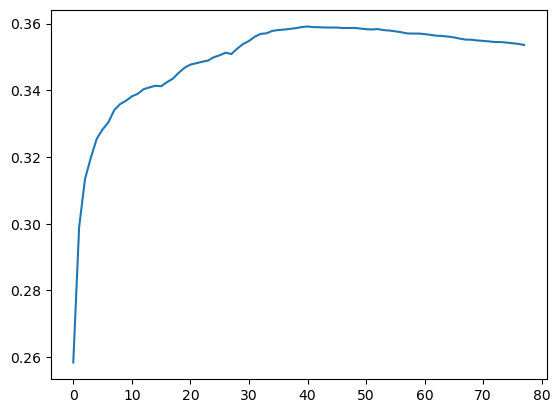

In [14]:
plt.plot(r2_all_array.mean(axis=0))

## performance analysis 

In [ ]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, device, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

/tmp/ipykernel_991847/3854074521.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r2 = np.corrcoef(torch.tensor(y_label).reshape(-1), prediction.detach().cpu().numpy().reshape(-1))[0,1]**2


[0.3536000867723633, 0.3515763975053103, 0.3683508062817459, 0.3484346178556437, 0.34928082851017367] 0.35424854738504735


In [14]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.35090627725752666, 0.34574344406430696, 0.35974062016998226, 0.33428008965083833, 0.34033690686505147] 0.34620146760154114


In [11]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.34676080861023645, 0.34001529593583874, 0.3581471294555243, 0.3291381092584444, 0.33525244364210216] 0.3418627573804292


In [31]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.34124305154047907, 0.33429049317908904, 0.3544312429865615, 0.3243167483168465, 0.33257982033558037] 0.33737227127171127


In [29]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.3408887960003255, 0.3326585830346959, 0.353235820195374, 0.3224689266240401, 0.33105475080677427] 0.336061375332242


In [27]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.3389598601008053, 0.32994289753704054, 0.3520788522282898, 0.32100578754095677, 0.32993013536173615] 0.33438350655376575


In [25]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls,fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.3368769377897742, 0.32493789592481026, 0.34810858197283356, 0.3167857291405009, 0.3273988213573304] 0.33082159323704985


In [19]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls,fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.3340978315116516, 0.3188870908666155, 0.34326885732316437, 0.31365926049244675, 0.32361275531649203] 0.3267051591020741


In [21]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls,fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.32825491942645535, 0.3122822984478497, 0.3355368097203841, 0.308689421236851, 0.319703338742639] 0.32089335751483583


In [23]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls,fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.3198074552812821, 0.3036073623134336, 0.32826100750579623, 0.2996257923659276, 0.3074256168585508] 0.31174544686499805


## Bias-Variance decomposition